In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from scipy.ndimage import fourier_shift
from scipy.interpolate import interp1d
from scipy import signal

# Signal Alignment
Theory
------

Two correlated signals can be aligned by determining the cross-correlation maxima (minimia) for positively (negatively) correlated signals. The following equation assumes that we take the maxima.
$$ \tau_\mathrm{delay}=\underset{t}{\operatorname{arg\,max}}((f \star g)(t))$$

where:
 * $f$ is the reference signal.
 * $g$ is the target signal to be delayed to align with $f$
 
The cross-correlation is a convolution of $f$ and $g$ in the time-domain, which can be converted to a multiplication in the frequency-domain.
$$ \tau_\mathrm{delay}=\underset{t}{\operatorname{arg\,max}}((\mathcal{F}\left\{f\right\} \cdot \mathcal{F}\left\{g\right\}^*))$$

Notes:
------
- Since delay calculated here is always positive:
    - **The target signal $g$ must always *lag* the reference signal $f$ by < $t_{stop}$.**
- Signals with sub-periodic periodic behaviour have additional requirements:
    - **The target signal $g$ must always *lag* the reference signal $f$ by < T (where T < $t_{stop}$).**
    - **You must specify the period, by default T = $t_{stop}$.**

In [35]:
def _upsampled_dft(data, upsampled_region_size,
                   upsample_factor=1, axis_offsets=0):
    """
        Upsampled DFT by matrix multiplication.

        This code is intended to provide the same result as if the following
        operations were performed:
            - Embed the array "data" in an array that is ``upsample_factor`` times
              larger in each dimension.  ifftshift to bring the center of the
              image to (1,1).
            - Take the FFT of the larger array.
            - Extract an ``[upsampled_region_size]`` region of the result, starting
              with the ``[axis_offsets+1]`` element.

        It achieves this result by computing the DFT in the output array without
        the need to zeropad. Much faster and memory efficient than the zero-padded
        FFT approach if ``upsampled_region_size`` is much smaller than
        ``data.size * upsample_factor``.

        Parameters
        ----------
        data : 1D ndarray
            The input data array (DFT of original data) to upsample.
        upsampled_region_size : integer, optional
            The size of the region to be sampled.  If one integer is provided, it
            is duplicated up to the dimensionality of ``data``.
        upsample_factor : integer, optional
            The upsampling factor.  Defaults to 1.
        axis_offsets : integer, optional
            The offsets of the region to be sampled.  Defaults to None (uses
            image center)

        Returns
        -------
        output : 1D ndarray
                The upsampled DFT of the specified region.
    """
    row_kernel = np.exp(
            (-1j * 2 * np.pi / (data.shape[0] * upsample_factor)) *
            (np.arange(upsampled_region_size)[:, None] - axis_offsets).dot(
                np.fft.ifftshift(np.arange(data.shape[0]))[None, :] -
                np.floor(data.shape[0] / 2))
        )

    return row_kernel.dot(data)

## Create the Reference Signal (f)

In [53]:
upsample = 100
Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector
t_upsampled = np.arange(0, 1, Ts/upsample)

ff = 6;   # frequency of the signal
T = t[-1]/ff

# let's generate a sine signal
f = np.sin(2*np.pi*ff*t) + 0.5*1j*np.cos(2*np.pi*ff*t)
# sig = np.sin(2 * np.pi * t)
# f = signal.square(2 * np.pi * 30 * t, duty=(sig + 1)/2) + 0.5*1j*signal.square(2 * np.pi * 15 * t, duty=(sig + 1)/2)
T, Ts

(0.16555555555555557, 0.006666666666666667)

## Create Delayed Reference Signal (g)

In [54]:
# shift the signal in the frequency domain
delay = 27.35
g = fft(f)
g = fourier_shift(g, delay, n=-1, axis=-1)
g = ifft(g)

# or shift the signal in the time domain
g = signal.resample(f, f.size*upsample)
g = np.roll(g, int(delay*upsample))
g[0:int(delay*upsample)] = 0  # zero signal before the start to approximate single playback (non-periodic signals)
g = signal.resample(g, f.size)

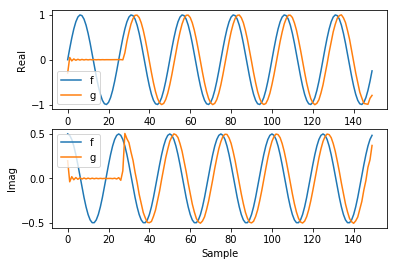

In [55]:
plt.figure(1)

plt.subplot(211)
plt.plot(f.real, label = 'f')
plt.plot(g.real, label = 'g')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.subplot(212)
plt.plot(f.imag, label = 'f')
plt.plot(g.imag, label = 'g')
plt.xlabel('Sample')
plt.ylabel('Imag')
plt.legend()

plt.show()

## Pad the signal with zeros to convert from circular convolution to linear convolution

In [56]:
size = f.size + g.size - 1
f_pad = np.concatenate((f, np.zeros(size)))
g_pad = np.concatenate((g, np.zeros(size)))

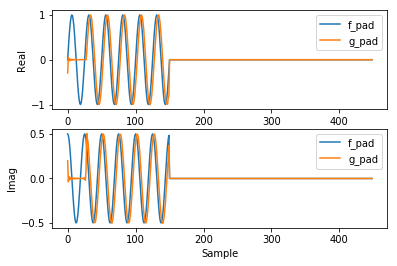

In [57]:
plt.figure(3)

plt.subplot(211)
plt.plot(f_pad.real, label = 'f_pad')
plt.plot(g_pad.real, label = 'g_pad')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.subplot(212)
plt.plot(f_pad.imag, label = 'f_pad')
plt.plot(g_pad.imag, label = 'g_pad')
plt.xlabel('Sample')
plt.ylabel('Imag')
plt.legend()

plt.show()

## Calculate Shift 
 - Cross correlation is always positive, so the shift is always indicated by the maxima
 - It is impossible to determine the direction of the shift if the signal is periodic.
 - This algorithm will always calculated a positive (circular) shift.
 - The period of the signal (envelope) must be manually specified to determine if there is negative shift.

In [58]:
f_freq = fft(f_pad)
g_freq = fft(g_pad)

# Calculate Cross Correlation
product = f_freq.conj()*g_freq
cross_correlation = ifft(product)[0:size]

# Locate maxima
shape = f_freq.shape
maxima = np.argmax(cross_correlation)
minima = np.argmin(cross_correlation)
period = np.argmax(t > T)
period = len(t) if period == 0 else period
shift = maxima % period

In [59]:
maxima, minima

(2, 15)

In [60]:
cross_correlation[maxima], cross_correlation[minima]

((76.888124756783739+5.3694422215666657j),
 (-77.04571616287086+2.3086814606420272j))

In [61]:
shift

2

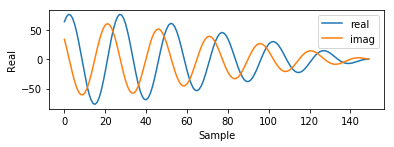

In [62]:
plt.figure(4)

plt.subplot(211)
plt.plot(cross_correlation.real[0:150], label = 'real')
plt.plot(cross_correlation.imag[0:150], label = 'imag')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.show()

Calculate Sub-Shift
--------------------

In [63]:
if upsample > 1:
    # Initial shift estimate in upsampled grid
    shift = np.round(shift*upsample)/upsample
    upsampled_region_size = np.ceil(upsample*1.5)

    # Center of output array at dftshift + 1
    dftshift = np.fix(upsampled_region_size / 2.0)
    normalization = (f.size*upsample**2)

    # Matrix multiply DFT around the current shift estimate
    sample_region_offset = dftshift - shift*upsample
    cross_correlation = _upsampled_dft(product.conj(), upsampled_region_size,
                                       upsample_factor=upsample, axis_offsets=sample_region_offset)
    cross_correlation = cross_correlation.conj()/normalization
    # Locate maximum and map back to original pixel grid
    maxima = np.argmax(np.abs(cross_correlation))
    maxima -= dftshift
    shift = shift + maxima / upsample

C:\Users\db888079\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


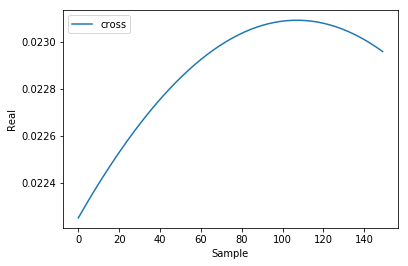

In [64]:
plt.figure(3)

plt.plot(cross_correlation, label = 'cross')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.show()

In [65]:
maxima

27.0

In [66]:
cross_correlation[maxima]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [67]:
shift

2.27

## Apply Shift

In [68]:
g_new = fft(g)
g_new = fourier_shift(g_new, -shift, n=-1, axis=-1)
g_new = ifft(g_new)

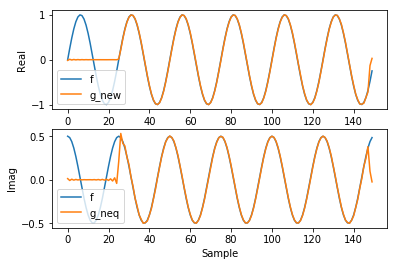

In [69]:
plt.figure(1)

plt.subplot(211)
plt.plot(f.real, label = 'f')
plt.plot(g_new.real, label = 'g_new')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.subplot(212)
plt.plot(f.imag, label = 'f')
plt.plot(g_new.imag, label = 'g_neq')
plt.xlabel('Sample')
plt.ylabel('Imag')
plt.legend()

plt.show()